## Example of using BigQuery and Pandas together

This notebook illustrates a typical data science workflow that leverages the relative advantages of both Pandas and BigQuery:
* Pandas for transformations and graphics.
* BigQuery for scale


## Install library and extensions if needed

In [4]:
#!pip install google-cloud-bigquery
%load_ext google.cloud.bigquery

In [2]:
PROJECT='cloud-training-demos'  # CHANGE THIS


## Problem

We believe that if someone rents a bicycle for less than 10 minutes and returns the bicycle to the same station that they rented it at, it is likely that the bicycle has a problem. We'll call this a "bad" trip.

We want to send a crew out to examine a few of the stations that had lots of bad trips to see if there are any systemic problems.

### Find stations with problem bikes
As a first step, let's find which stations had the most "bad" trips in 2015

In [29]:
%%bigquery badtrips --project $PROJECT
SELECT *, bad_trips / num_trips AS fraction_bad FROM (
    SELECT 
      start_station_name
      , SUM(IF(duration < 600 AND start_station_name = end_station_name, 1, 0)) AS bad_trips
      , COUNT(start_station_name) as num_trips
    FROM `bigquery-public-data`.london_bicycles.cycle_hire
    WHERE EXTRACT(YEAR FROM start_date) = 2015
    GROUP BY start_station_name
    HAVING num_trips > 10
)
ORDER BY fraction_bad DESC

,start_station_name,bad_trips,num_trips,fraction_bad
0,"Contact Centre, Southbury House",20,48,0.416667
1,"Monier Road, Newham",1,25,0.040000
2,"Aberfeldy Street, Poplar",35,955,0.036649
3,"Ormonde Gate, Chelsea",315,8932,0.035266
4,"Thornfield House, Poplar",28,947,0.029567
5,"Langdon Park, Poplar",74,2724,0.027166
6,"River Street , Clerkenwell",221,8279,0.026694
7,"Grenfell Road, Avondale",82,3650,0.022466
8,"Newby Place, Poplar",73,3295,0.022155
9,"Courland Grove, Wandsworth Road",105,5369,0.019557


### Statistics

Let's look at the statistics of the dataset to learn what kind of threshold of the fraction_bad is appropriate

In [30]:
badtrips.describe()

,bad_trips,num_trips,fraction_bad
count,823.000000,823.000000,823.000000
mean,75.074119,11869.755772,0.007636
std,70.512207,9906.268656,0.014739
min,0.000000,11.000000,0.000000
25%,41.000000,5903.000000,0.005002
50%,62.000000,9998.000000,0.006368
75%,91.500000,14852.500000,0.008383
max,967.000000,95740.000000,0.416667


Looks like the fraction_bad ranges from 0 to 0.4, but is not clear how relevant this ratio is because the stations also vary quite dramatically. For example, the number of trips ranges from 11 to 95740.  A 0.4 fraction_bad is not terrible if num_trips=11.

Let's look at a scatter plot to see if there is any clear trend here.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


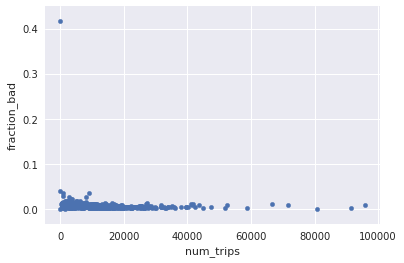

In [52]:
badtrips.plot.scatter('num_trips', 'fraction_bad');

Let's zoom in a bit and add a line of best fit

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


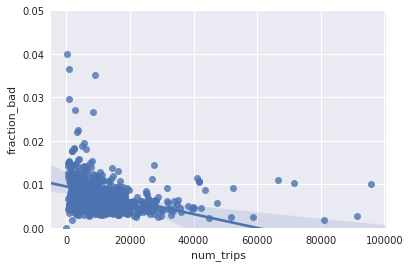

In [54]:
import seaborn as sns
ax = sns.regplot(badtrips['num_trips'],badtrips['fraction_bad']);
ax.set_ylim(0, 0.05);

Indeed, we see that higher fraction_bad are associated with lower num_trips.  We need to use the fraction_bad carefully.

### Banding
Let's pick the 5 worst of the really busy stations, 5 of the next most busy, etc.
We can do this by creating
4 different bands from the quantile of the station by num_trips, and within each band, finding the 5 stations that are most bad.

In [57]:
stations_to_examine = []

import pandas as pd
for band in range(1,5):
  min_trips = badtrips['num_trips'].quantile(0.2*(band))
  max_trips = badtrips['num_trips'].quantile(0.2*(band+1))
  query = 'num_trips >= {} and num_trips < {}'.format(min_trips, max_trips)
  print(query) # band
  stations = badtrips.query(query)
  stations = stations.sort_values(by=['fraction_bad'], ascending=False)[:5] 
  print(stations) # 5 worst
  stations_to_examine.append(stations)
  print()

num_trips >= 4826.4 and num_trips < 8511.8
                 start_station_name  bad_trips  num_trips  fraction_bad
6        River Street , Clerkenwell        221       8279      0.026694
9   Courland Grove, Wandsworth Road        105       5369      0.019557
10         Stanley Grove, Battersea         92       4882      0.018845
12              Southern Grove, Bow        112       6152      0.018205
18    Richmond Way, Shepherd's Bush        126       8149      0.015462

num_trips >= 8511.8 and num_trips < 11502.6
                  start_station_name  bad_trips  num_trips  fraction_bad
3              Ormonde Gate, Chelsea        315       8932      0.035266
41  Emperor's Gate, South Kensington        136      10554      0.012886
53     Chepstow Villas, Notting Hill        135      11038      0.012230
57            Salmon Lane, Limehouse        113       9345      0.012092
63       Greyhound Road, Hammersmith        118       9998      0.011802

num_trips >= 11502.6 and num_trips < 1650

Notice how, by banding, we are able to use lower thresholds for the busier stations. Had we chosen a single threshold, our crew would have not get to look at a diverse set of stations.

### Stations to examine

In [58]:
stations_to_examine = pd.concat(stations_to_examine)
stations_to_examine

,start_station_name,bad_trips,num_trips,fraction_bad
6,"River Street , Clerkenwell",221,8279,0.026694
9,"Courland Grove, Wandsworth Road",105,5369,0.019557
10,"Stanley Grove, Battersea",92,4882,0.018845
12,"Southern Grove, Bow",112,6152,0.018205
18,"Richmond Way, Shepherd's Bush",126,8149,0.015462
3,"Ormonde Gate, Chelsea",315,8932,0.035266
41,"Emperor's Gate, South Kensington",136,10554,0.012886
53,"Chepstow Villas, Notting Hill",135,11038,0.012230
57,"Salmon Lane, Limehouse",113,9345,0.012092
63,"Greyhound Road, Hammersmith",118,9998,0.011802


### Write the stations to a new table in BigQuery

In [ ]:
!pip install pyarrow

In [62]:
from google.cloud.bigquery.table import TableReference
from google.cloud import bigquery
bq = bigquery.Client(project=PROJECT)

tblref = TableReference.from_string(
                  '{}.ch05eu.bad_bikes'.format(PROJECT))
job = bq.load_table_from_dataframe(stations_to_examine, tblref)
job.result() # blocks and waits
print("Loaded {} rows into {}".format(job.output_rows, tblref.table_id))

Loaded 20 rows into bad_bikes


### Plot map for crew

Add latitude and longitude through a join

In [78]:
%%bigquery stations_to_examine --project $PROJECT
SELECT 
  start_station_name AS station_name
  , num_trips
  , fraction_bad
  , latitude
  , longitude
FROM ch05eu.bad_bikes AS bad
JOIN `bigquery-public-data`.london_bicycles.cycle_stations AS s
ON bad.start_station_name = s.name

,station_name,num_trips,fraction_bad,latitude,longitude
0,"Ormonde Gate, Chelsea",8932,0.035266,51.487964,-0.161765
1,"Stanley Grove, Battersea",4882,0.018845,51.470475,-0.152130
2,"Courland Grove, Wandsworth Road",5369,0.019557,51.472918,-0.132103
3,"Southern Grove, Bow",6152,0.018205,51.523538,-0.030556
4,"Salmon Lane, Limehouse",9345,0.012092,51.514115,-0.033828
5,"Greyhound Road, Hammersmith",9998,0.011802,51.486062,-0.214428
6,"Richmond Way, Shepherd's Bush",8149,0.015462,51.500353,-0.217515
7,"Westfield Library Corner, Shepherd's Bush",11517,0.010940,51.506093,-0.224224
8,"Chepstow Villas, Notting Hill",11038,0.012230,51.512137,-0.201555
9,"Emperor's Gate, South Kensington",10554,0.012886,51.495362,-0.185297


In [65]:
!pip install folium

    100% |████████████████████████████████| 92kB 4.9MB/s ta 0:00:01


In [80]:
import folium
map_pts = folium.Map(location=[51.5, -0.15], zoom_start=12)
for idx, row in stations_to_examine.iterrows():
  folium.Marker( location=[row['latitude'], row['longitude']], popup=row['station_name'] ).add_to(map_pts)
map_pts

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License